# Convert your 2D CAD Drawing into 3D CAD Models
## Outline

This notebook is used for generating 3D CAD models given 3 views of the model, namely front, side and top view. 
## Dimensioning function
The following funtion is used for dimensioning step, where you have to provide the all the 3 views images and the output of this function will be the image highlighted with a line and the unit length to pixel value. Once you get the raito value you can multiple it with the length of the highlighted line to get the length to pixel ratio for that view.

In [1]:
import copy
import json
import os
import shutil
import cv2
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import Image

from utils.shape import node
from utils.tree import createtree
from utils.operation import *




def Dimensioning(userId,view,image):

    #Creating temp directory if not present
    os.makedirs('static/temp', exist_ok=True)
    #Getting user input from app
    img = cv2.imread(image,cv2.IMREAD_UNCHANGED)
    #Initialization
    ratio = 0
    shape = "unidentified"
    #Getting the size of image
    try:
        w,h,_=img.shape
        drawSize = int(h/300)
        # if(drawSize == 0):
        #     drawSize = 1
        #Convert image to grayscale
        imgrey = cv2.cvtColor(img.copy(),cv2.COLOR_BGR2GRAY)
        #Convert image to black and white
        ret, thresh = cv2.threshold(imgrey,127,255,cv2.THRESH_BINARY_INV)
        #Find contours
        contours, hierarchy = cv2.findContours(thresh,cv2.RETR_CCOMP,cv2.CHAIN_APPROX_SIMPLE)
        #Arrange the contours in descending order of area
        hierarchy,contours = zip(*sorted(zip(hierarchy[0],contours),key = lambda x: cv2.contourArea(x[1]),reverse=True))

        for i,c in enumerate(contours):
            #Get the outer most closed contour
            if(hierarchy[i][3] != -1  or (hierarchy[i][3] == -1 and hierarchy[i][2] == -1) ):
                M = cv2.moments(c)
                if(M["m00"] !=0):
                    cX = int(M["m10"] / M["m00"])
                    cY = int(M["m01"] / M["m00"])
                    #Getting the minimum area rectangle enclosing the contour
                    rect = cv2.minAreaRect(c)
                    box = cv2.boxPoints(rect)
                    box = np.int0(box)
                    #Getting horizontal rectangle enclosing the contour
                    x,y,w,h = cv2.boundingRect(c)

                    # cv2.putText(img, "#{}".format(i), (box[0][0], box[0][1]), cv2.FONT_HERSHEY_SIMPLEX,
                    #     textSize, (255, 0, 0), drawSize,cv2.LINE_AA)

                    #detect Shape
                    shape, cylinder_type = detect(c)              
                    if(shape == "unidentified"):
                        continue

                    if(shape=="triangle" or shape=="pentagon" or shape=="hexagon"):
                        img = cv2.drawContours(img, [box], 0, (0,0, 255), drawSize)
                    # w is the width of the rectagle enclosing the circle, i.e diameter of the circle
                    if(shape=="circle"):
                        # draw contours
                        img = cv2.rectangle(img,(x,y),(x+w,y+h),(0, 0, 255),drawSize)
                        cv2.line(img, (x,y), (x+w,y), (0,255, 0), 2)
                        ratio = 1/w
                    else:
                        # draw contours
                        # img = cv2.drawContours(img, [box], 0, (0,0, 255), drawSize)
                        cv2.line(img, tuple(box[0]), tuple(box[1]), (0,255, 0), 2)
                        #Length per pixel
                        ratio = 1.0/rect[1][1]
                    break

        #highlighted image path
        folder = 'static/temp/' + userId
        os.makedirs(folder, exist_ok=True)
        #Check whether file already exist and delete
        try:
            os.remove(folder + '/' + view + '.jpg')
        except: pass

        path_file = (folder + '/' + view + '.jpg')

        #reducing the image size
        small = cv2.resize(img, (0,0), fx=0.5, fy=0.5) 
        cv2.imwrite(path_file,small)
        #Convert float to string
        ratio = str(ratio)
        #Json data to send
        data={'image': path_file,'shape': shape,'ratio': ratio}
    #     plt.imshow(image)
    #     plt.show()

        display(Image(filename = path_file))
        return data
    except:
      print(view + "image not found")

## Converting function
This takes in all the 3 images and the length to pixel ratio for each view and created the 3D scad Model. ALso provide the unique userId which will be used to name the final scad file. you can see all the results in static folder

In [2]:
import time

def Convert(userId, front_image, side_image, top_image, fratio, sratio, tratio):
    # store starting time 
    start = time.time() 
    os.makedirs('static/'+userId, exist_ok=True)

    img_front = cv2.imread(front_image,cv2.IMREAD_UNCHANGED)
    img_side = cv2.imread(side_image,cv2.IMREAD_UNCHANGED)
    img_top = cv2.imread(top_image,cv2.IMREAD_UNCHANGED)

    fratio = float(fratio)
    sratio = float(sratio)
    tratio = float(tratio)
    filePath = "static/temp/"+userId
#Remove temp file created while dimensioning
    try:
        shutil.rmtree(filePath)
    except OSError as e:
        print ("Error: %s - %s." % (e.filename, e.strerror))

    primitive = []
    #front
    object_front = valid_contours(img_front,"front",fratio)
    re_arrange(object_front,"front")
    
    #side
    object_side = valid_contours(img_side,"side",sratio)
    re_arrange(object_side,"side")

    #Top
    object_top = valid_contours(img_top,"top",tratio)
    re_arrange(object_top,"top")

    #Thershold error        
#     minApprox = 4 * max(fratio,sratio,tratio)
    minApprox = 0.05
    primitive = combining(object_front,object_side,object_top,minApprox)
    final = []
    for set in primitive:
        for shape in set:
            final.append(shape[0])
    
    #Check whether file already exist and delete
    try:
        os.remove('static/' + userId + "/" + userId + '.scad')
    except: pass

    #Generate scad file
    path_file = ('static/' + userId + "/" + userId + '.scad')
    #If the list is empty no shape has been detected
    if(len(final) == 0):
        path_file = 'static/error.txt'
        f = open(path_file, "w")
        f.write("Cannot determine the 3d geometry, check your files again!")
        f.close()
    createtree(final,path_file)
    # store end time 
    end = time.time() 
    print("Total time taken to convert:",end-start)
    return path_file


## Sample run
Setting the image fiel path 

In [3]:
userId="3"
front_image = "TestBench/"+userId+"/front.jpg"
side_image = "TestBench/"+userId+"/side.jpg"
top_image = "TestBench/"+userId+"/top.jpg"
front_image

'TestBench/3/front.jpg'

Calling Dimensioning function for front view

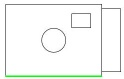

{'image': 'static/temp/3/front.jpg',
 'shape': 'rectangle',
 'ratio': '0.005208333333333333'}

In [4]:
d1 = Dimensioning(userId,"front",front_image)
d1

Calling Dimensioning function for side view

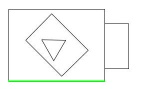

{'image': 'static/temp/3/side.jpg',
 'shape': 'rectangle',
 'ratio': '0.005208333333333333'}

In [5]:
d2 = Dimensioning(userId,"side",side_image)
d2

Calling Dimensioning function for top view

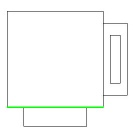

{'image': 'static/temp/3/top.jpg',
 'shape': 'square',
 'ratio': '0.005208333333333333'}

In [6]:
d3 = Dimensioning(userId,"top",top_image)
d3

Multiply the ratio provided in the dimensioning step with the highlighted length

This is done because lets say the images are taken from camera the the pixel to dimension ratio
might changes for each view, so we take the pixel to dimension ratio for converions

In [7]:

fratio = float(d1["ratio"]) * 2 #Width of rectangle in highlighted in front view 
sratio = float(d2["ratio"]) * 2 #Width of rectangle in highlighted in front view
tratio = float(d3["ratio"]) * 2 #Width of rectangle in highlighted in front view

Call the function to convert the images to 3D scad model and the file path for scad is provided as output

In [8]:
Convert(userId,front_image, side_image, top_image,fratio, sratio, tratio)

Subtree: 3
Total time taken to convert: 0.02801370620727539


'static/3/3.scad'

Wait for a minute after running the following code, it will be running in the background. It will open a interactive window to view your 3D model and also creates the stl and pcd type files.

In [10]:
from subprocess import run
import open3d as o3d
import time
from pyntcloud import PyntCloud

print("please wait...")
# store starting time 
start = time.time() 
scad_filename = "static/" + userId + '/' + userId + ".scad"
stl_filename = "static/" + userId + '/' + userId + ".stl"
pcd_filename = "static/" + userId + '/' + userId + ".pcd"


if(os.path.isfile(scad_filename)):
    run("openscadExec/openscad.exe -o " + stl_filename + " " + scad_filename)
    if(os.path.isfile(stl_filename)):
        print("stl file generated at " + stl_filename)
        mesh = o3d.io.read_triangle_mesh(stl_filename)
        pointcloud = mesh.sample_points_poisson_disk(100000)
        o3d.io.write_point_cloud(pcd_filename, pointcloud)
        model = PyntCloud.from_file(pcd_filename)
        print("pcd file generated at " + pcd_filename)
        model.plot()
        # store end time 
        end = time.time() 
        print("Total time taken to convert from stl to point cloud:",end-start)
    else:
        print("file not found")
else:
    print("scad file not found")

please wait...
stl file generated at static/3/3.stl
pcd file generated at static/3/3.pcd


Renderer(camera=PerspectiveCamera(aspect=1.6, fov=90.0, position=(0.13218626379966736, 1.704128846526146, 1.15…

Total time taken to convert from stl to point cloud: 50.857945919036865
